# GRN Inference on Pre-trained Model
Here we use the pre-trained blood model as an example for GRN inference, particularly regarding gene program extraction and network visualization. We also present the cell-type specific activations within these gene programs on the Immune Human dataset, as a soft validation for the zero-shot performance. 

Note that GRN inference can be performed on pre-trained and finetuned models as showcased in our manuscript.

Users may perform scGPT's gene-embedding-based GRN inference in the following steps:

     1. Load optimized scGPT model (pre-trained or fine-tuned) and data
     
     2. Retrieve scGPT's gene embeddings
     
     3. Extract gene programs from scGPT's gene embedding network
     
     4. Visualize gene program activations on dataset of interest
     
     5. Visualize the interconnectivity of genes within select gene programs
     

In [1]:
import copy
import json
import os
from pathlib import Path
import sys
import warnings

import torch
from anndata import AnnData
import scanpy as sc
import numpy as np

# %matplotlib agg
import matplotlib.pyplot as plt
import seaborn as sns
import networkx as nx
import pandas as pd
import tqdm
import gseapy as gp

from torchtext.vocab import Vocab
from torchtext._torchtext import (
    Vocab as VocabPybind,
)

sys.path.insert(0, "../")
import scgpt as scg
from scgpt.tasks import GeneEmbedding
from scgpt.tokenizer.gene_tokenizer import GeneVocab
from scgpt.model.model_main import TransformerModel
from scgpt.preprocess import Preprocessor
from scgpt.utils import set_seed 

os.environ["KMP_WARNINGS"] = "off"
warnings.filterwarnings('ignore')

/hy-tmp/lcx/env/lcx/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
2025-07-21 16:30:33.216157: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F AVX512_VNNI FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2025-07-21 16:30:33.342326: I tensorflow/core/util/port.cc:104] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
/hy-tmp/lcx/env/lcx/lib/python3.10/site-packages/tensorflow/python/framework/dtypes.py:246

In [2]:
set_seed(42)
pad_token = "<pad>"
special_tokens = [pad_token, "<cls>", "<eoc>"]
n_hvg = 3000
n_bins = 51
mask_value = -1
pad_value = -2
n_input_bins = n_bins

## Step 1: Load pre-trained model and dataset

### 1.1  Load pre-trained model
The blood pre-trained model can be downloaded via this [link](https://drive.google.com/drive/folders/1kkug5C7NjvXIwQGGaGoqXTk_Lb_pDrBU).

In [3]:
# Specify model path; here we load the pre-trained scGPT blood model
# model_dir = Path("/hy-tmp/lcx/scGPT/run/save/eval-Jun01-16-02-2025")
model_dir = Path("/hy-tmp/lcx/ckpt/")

model_config_file = model_dir / "args.json"
model_file = model_dir / "best_model.pt"
vocab_file = model_dir / "vocab.json"

vocab = GeneVocab.from_file(vocab_file)
for s in special_tokens:
    if s not in vocab:
        vocab.append_token(s)

# Retrieve model parameters from config files
with open(model_config_file, "r") as f:
    model_configs = json.load(f)
print(
    f"Resume model from {model_file}, the model args will override the "
    f"config {model_config_file}."
)
embsize = model_configs["embsize"]
nhead = model_configs["nheads"]
d_hid = model_configs["d_hid"]
nlayers = model_configs["nlayers"]
n_layers_cls = model_configs["n_layers_cls"]

gene2idx = vocab.get_stoi()

Resume model from /hy-tmp/lcx/ckpt/best_model.pt, the model args will override the config /hy-tmp/lcx/ckpt/args.json.


In [4]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

ntokens = len(vocab)  # size of vocabulary
model = TransformerModel(
    ntokens,
    embsize,
    nhead,
    d_hid,
    nlayers,
    vocab=vocab,
    pad_value=pad_value,
    n_input_bins=n_input_bins,
)

try:
    model.load_state_dict(torch.load(model_file))
    print(f"Loading all model params from {model_file}")
except:
    # only load params that are in the model and match the size
    model_dict = model.state_dict()
    pretrained_dict = torch.load(model_file)
    pretrained_dict = {
        k: v
        for k, v in pretrained_dict.items()
        if k in model_dict and v.shape == model_dict[k].shape
    }
    for k, v in pretrained_dict.items():
        print(f"Loading params {k} with shape {v.shape}")
        model_dict.update(pretrained_dict)
        model.load_state_dict(model_dict)

model.to(device)

Loading params encoder.embedding.weight with shape torch.Size([40158, 256])
Loading params encoder.enc_norm.weight with shape torch.Size([256])
Loading params encoder.enc_norm.bias with shape torch.Size([256])
Loading params value_encoder.linear1.weight with shape torch.Size([256, 1])
Loading params value_encoder.linear1.bias with shape torch.Size([256])
Loading params value_encoder.linear2.weight with shape torch.Size([256, 256])
Loading params value_encoder.linear2.bias with shape torch.Size([256])
Loading params value_encoder.norm.weight with shape torch.Size([256])
Loading params value_encoder.norm.bias with shape torch.Size([256])
Loading params transformer_encoder.layers.0.self_attn.out_proj.weight with shape torch.Size([256, 256])
Loading params transformer_encoder.layers.0.self_attn.out_proj.bias with shape torch.Size([256])
Loading params transformer_encoder.layers.0.linear1.weight with shape torch.Size([256, 256])
Loading params transformer_encoder.layers.0.linear1.bias with 

TransformerModel(
  (encoder): GeneEncoder(
    (embedding): Embedding(40158, 256, padding_idx=40155)
    (enc_norm): LayerNorm((256,), eps=1e-05, elementwise_affine=True)
  )
  (value_encoder): ContinuousValueEncoder(
    (dropout): Dropout(p=0.5, inplace=False)
    (linear1): Linear(in_features=1, out_features=256, bias=True)
    (activation): ReLU()
    (linear2): Linear(in_features=256, out_features=256, bias=True)
    (norm): LayerNorm((256,), eps=1e-05, elementwise_affine=True)
  )
  (transformer_encoder): TransformerEncoder(
    (layers): ModuleList(
      (0-5): 6 x TransformerEncoderLayer(
        (self_attn): MultiheadAttention(
          (out_proj): NonDynamicallyQuantizableLinear(in_features=256, out_features=256, bias=True)
        )
        (linear1): Linear(in_features=256, out_features=256, bias=True)
        (dropout): Dropout(p=0.5, inplace=False)
        (linear2): Linear(in_features=256, out_features=256, bias=True)
        (norm1): LayerNorm((256,), eps=1e-05, elem

### 1.2  Load dataset of interest
The Immune Human dataset can be downloaded via this [link](https://figshare.com/ndownloader/files/25717328).

In [5]:
# Specify data path; here we load the Immune Human dataset
data_dir = Path("/hy-tmp/lcx/zh11_rice_data")
adata = sc.read(
    str("/hy-tmp/lcx/zh11_rice_data/D5-15_celltype_part.h5ad"), cache=True
)  # 33506 × 12303
ori_batch_col = "stage"
# adata.obs["celltype"] = adata.obs["celltypeV4C"].astype(str)
adata.obs["celltype"] = adata.obs["celltype_L2"].astype(str)

data_is_raw = True

In [6]:
adata.obs["celltype_L2"].unique()

['Endosperm_adjacent_to_scutellum', 'Starchy_endosperm_3', 'Subaleurone', 'Dorsal_peripheral_endosperm', 'Aleurone', 'Starchy_endosperm_2', 'Ventral_peripheral_endosperm', 'Starchy_endosperm_1']
Categories (8, object): ['Aleurone', 'Dorsal_peripheral_endosperm', 'Endosperm_adjacent_to_scutellum', 'Starchy_endosperm_1', 'Starchy_endosperm_2', 'Starchy_endosperm_3', 'Subaleurone', 'Ventral_peripheral_endosperm']

In [7]:
adata

AnnData object with n_obs × n_vars = 131907 × 33134
    obs: 'project', 'celltype_L1', 'celltype_L2', 'stage', 'sample', 'x', 'y', 'UMAP_1', 'UMAP_2', 'tissue', 'celltype_L2_abbr', 'celltype_L1_abbr', 'celltype'
    var: 'n_cells'
    obsm: 'spatial', 'spatial_circle', 'spatial_o'

In [ ]:
# adata = adata[adata.obs['stage'].isin(['Day01', 'Day02', 'Day03', 'Day05', 'Day07'])]
# adata = adata[adata.obs['stage'] == 'DAP08']

In [8]:
# Preprocess the data following the scGPT data pre-processing pipeline
preprocessor = Preprocessor(
    use_key="X",  # the key in adata.layers to use as raw data
    filter_gene_by_counts=3,  # step 1
    filter_cell_by_counts=False,  # step 2
    normalize_total=1e4,  # 3. whether to normalize the raw data and to what sum
    result_normed_key="X_normed",  # the key in adata.layers to store the normalized data
    log1p=data_is_raw,  # 4. whether to log1p the normalized data
    result_log1p_key="X_log1p",
    subset_hvg=n_hvg,  # 5. whether to subset the raw data to highly variable genes
    hvg_flavor="seurat_v3" if data_is_raw else "cell_ranger",
    binning=n_bins,  # 6. whether to bin the raw data and to what number of bins
    result_binned_key="X_binned",  # the key in adata.layers to store the binned data
)
adata = preprocessor(adata, batch_key="sample")
# preprocessor(adata, batch_key=None)

scGPT - INFO - Filtering genes by counts ...


scGPT - INFO - Filtering cells by counts ...
scGPT - INFO - Normalizing total counts ...
scGPT - INFO - Log1p transforming ...
scGPT - INFO - Subsetting highly variable genes ...
scGPT - INFO - Binning data ...


In [9]:
adata

AnnData object with n_obs × n_vars = 131907 × 3092
    obs: 'project', 'celltype_L1', 'celltype_L2', 'stage', 'sample', 'x', 'y', 'UMAP_1', 'UMAP_2', 'tissue', 'celltype_L2_abbr', 'celltype_L1_abbr', 'celltype', 'n_counts', 'n_genes'
    var: 'n_cells', 'n_counts', 'highly_variable', 'highly_variable_rank', 'means', 'variances', 'variances_norm', 'highly_variable_nbatches'
    uns: 'log1p', 'hvg'
    obsm: 'spatial', 'spatial_circle', 'spatial_o', 'bin_edges'
    layers: 'X_normed', 'X_log1p', 'X_binned'

In [10]:
genes_to_check = [
    "ZH01G28140", "ZH05G27110", "ZH01G34230", "ZH01G09620", "ZH12G17080",
    "ZH07G13670", "ZH04G01440", "ZH03G05070", "ZH01G13090", "ZH01G13110",
    "ZH12G06450", "ZH02G13010", "ZH11G07360", "ZH11G07370", "ZH01G05600",
    "ZH04G17230", "ZH05G05550", "ZH03G43260", "ZH03G13140", "ZH03G11730", 
    "ZH05G21160", "ZH10G02750", "ZH11G05220", "ZH04G16830", "ZH01G10490",
    "ZH12G02820", "ZH11G02760", "ZH09G16920", "ZH06G26740", "ZH06G10140",
    "ZH05G31220", "ZH02G35800", "ZH01G47380", "ZH01G32910", "ZH01G27990",
    "ZH09G20640", "ZH05G04180", "ZH12G22990", "ZH11G08170", "ZH11G08160",
    "ZH08G00830", "ZH07G05600", "ZH06G22580", "ZH06G17100", "ZH08G00870",
    "ZH06G17920", "ZH05G29700", "ZH05G26670", "ZH05G09150", "ZH05G06700",
    "ZH05G06150", "ZH03G40620", "ZH03G28780", "ZH03G28770", "ZH02G41400",
    "ZH02G40280", "ZH02G34100", "ZH02G10600", "ZH01G34910", "ZH01G13940",
    "ZH12G23000", "ZH01G07190", "ZH01G06320", "ZH12G23940", "ZH12G15290",
    "ZH11G17010", "ZH10G15830", "ZH08G25040", "ZH07G05650", "ZH06G30160",
    "ZH06G28660", "ZH06G07720", "ZH05G29990", "ZH05G26090", "ZH04G34920",
    "ZH04G33340", "ZH04G32720", "ZH04G21420", "ZH04G15450", "ZH02G27480",
    "ZH02G22610", "ZH02G05810", "ZH01G48100", "ZH01G35800", "ZH01G29730",
    "ZH08G14810", "ZH05G31490", "ZH01G27360", "ZH07G09400", "ZH06G05220",
    "ZH06G09930", "ZH02G35950", "ZH10G13280", "ZH08G06670", "ZH04G29550",
    "ZH01G33320", "ZH06G02750", "ZH07G12580", "ZH06G32140", "ZH04G13260",
    "ZH02G20800", "ZH08G25090", "ZH05G17850", "ZH09G14590", "ZH04G02940",

    # "ZH01G09250", "ZH01G21510", "ZH01G24450", "ZH01G25380", "ZH01G25390",
    # "ZH01G31810", "ZH01G44680", "ZH02G14620", "ZH02G19910", "ZH03G18750",
    # "ZH03G19050", "ZH05G08380", "ZH05G19820", "ZH05G32200", "ZH08G26300",
    # "ZH12G05880", "ZH09G02980", "ZH11G16520", "ZH12G15110", "ZH05G09170",
    # "ZH12G25960", "ZH03G05920", "ZH02G42420", "ZH02G23600", "ZH04G16480",
    # "ZH03G26960", "ZH07G00370", "ZH03G09740", "ZH08G06020", "ZH07G20840",
    # "ZH01G22990", "ZH02G23470", "ZH02G23450", "ZH01G23010", "ZH04G16490",
    # "ZH04G16510", "ZH04G16470", "ZH07G02290", "ZH10G22520", "ZH03G00190",
    # "ZH04G16550", "ZH09G03690", "ZH11G20990", "ZH06G03410", "ZH02G05420",
    # "ZH09G05170", "ZH09G06210", "ZH07G07300", "ZH10G24060", "ZH03G08070",
    # "ZH03G08080", "ZH04G33980", "ZH04G33990", "ZH07G22570", "ZH07G22580",
    # "ZH11G23270", "ZH11G23330", "ZH11G23300", "ZH01G51370", "ZH10G09110",
    # "ZH11G23360", "ZH12G17200", "ZH12G17100", "ZH04G22150", "ZH04G20940",
    # "ZH07G03420", "ZH04G19470", "ZH02G42850", "ZH11G15410", "ZH02G10630",
    # "ZH10G20690", "ZH09G09870", "ZH03G20050", "ZH03G20060", "ZH11G23690",
    # "ZH05G30410", "ZH05G30430", "ZH05G31390", "ZH09G17120", "ZH04G27500",
    # "ZH01G10700", "ZH08G06410", "ZH07G18450"
]



In [11]:
existing_genes = [gene for gene in genes_to_check if gene in adata.var_names]
print("Genes present in adata:", len(existing_genes))

Genes present in adata: 98


In [12]:
existing_genes = [gene for gene in genes_to_check if gene in adata.var_names]
print("Genes present in adata:", existing_genes)

Genes present in adata: ['ZH01G28140', 'ZH01G34230', 'ZH01G09620', 'ZH12G17080', 'ZH07G13670', 'ZH04G01440', 'ZH03G05070', 'ZH01G13090', 'ZH01G13110', 'ZH12G06450', 'ZH02G13010', 'ZH01G05600', 'ZH04G17230', 'ZH05G05550', 'ZH03G43260', 'ZH03G13140', 'ZH03G11730', 'ZH05G21160', 'ZH10G02750', 'ZH04G16830', 'ZH01G10490', 'ZH12G02820', 'ZH11G02760', 'ZH09G16920', 'ZH06G26740', 'ZH06G10140', 'ZH05G31220', 'ZH02G35800', 'ZH01G47380', 'ZH01G32910', 'ZH01G27990', 'ZH09G20640', 'ZH05G04180', 'ZH12G22990', 'ZH11G08170', 'ZH11G08160', 'ZH08G00830', 'ZH07G05600', 'ZH06G22580', 'ZH06G17100', 'ZH06G17920', 'ZH05G29700', 'ZH05G26670', 'ZH05G09150', 'ZH05G06700', 'ZH05G06150', 'ZH03G40620', 'ZH03G28780', 'ZH03G28770', 'ZH02G41400', 'ZH02G40280', 'ZH02G34100', 'ZH02G10600', 'ZH01G34910', 'ZH01G13940', 'ZH12G23000', 'ZH01G07190', 'ZH01G06320', 'ZH12G23940', 'ZH12G15290', 'ZH11G17010', 'ZH10G15830', 'ZH08G25040', 'ZH06G30160', 'ZH06G28660', 'ZH06G07720', 'ZH05G29990', 'ZH05G26090', 'ZH04G34920', 'ZH04G333

In [13]:
existing_genes = [gene for gene in genes_to_check if gene in adata.var_names]
print("Genes present in adata:", existing_genes)

Genes present in adata: ['ZH01G28140', 'ZH01G34230', 'ZH01G09620', 'ZH12G17080', 'ZH07G13670', 'ZH04G01440', 'ZH03G05070', 'ZH01G13090', 'ZH01G13110', 'ZH12G06450', 'ZH02G13010', 'ZH01G05600', 'ZH04G17230', 'ZH05G05550', 'ZH03G43260', 'ZH03G13140', 'ZH03G11730', 'ZH05G21160', 'ZH10G02750', 'ZH04G16830', 'ZH01G10490', 'ZH12G02820', 'ZH11G02760', 'ZH09G16920', 'ZH06G26740', 'ZH06G10140', 'ZH05G31220', 'ZH02G35800', 'ZH01G47380', 'ZH01G32910', 'ZH01G27990', 'ZH09G20640', 'ZH05G04180', 'ZH12G22990', 'ZH11G08170', 'ZH11G08160', 'ZH08G00830', 'ZH07G05600', 'ZH06G22580', 'ZH06G17100', 'ZH06G17920', 'ZH05G29700', 'ZH05G26670', 'ZH05G09150', 'ZH05G06700', 'ZH05G06150', 'ZH03G40620', 'ZH03G28780', 'ZH03G28770', 'ZH02G41400', 'ZH02G40280', 'ZH02G34100', 'ZH02G10600', 'ZH01G34910', 'ZH01G13940', 'ZH12G23000', 'ZH01G07190', 'ZH01G06320', 'ZH12G23940', 'ZH12G15290', 'ZH11G17010', 'ZH10G15830', 'ZH08G25040', 'ZH06G30160', 'ZH06G28660', 'ZH06G07720', 'ZH05G29990', 'ZH05G26090', 'ZH04G34920', 'ZH04G333

In [14]:
"ZH01G27360" in adata.var_names

True

## Step 2: Retrieve scGPT's gene embeddings

Note that technically scGPT's gene embeddings are data independent. Overall, the pre-trained foundation model contains 30+K genes. Here for simplicity, we focus on a subset of HVGs specific to the data at hand.

In [15]:
# Retrieve the data-independent gene embeddings from scGPT
gene_ids = np.array([id for id in gene2idx.values()])
gene_embeddings = model.encoder(torch.tensor(gene_ids, dtype=torch.long).to(device))
gene_embeddings = gene_embeddings.detach().cpu().numpy()

In [16]:
# Filter on the intersection between the Immune Human HVGs found in step 1.2 and scGPT's 30+K foundation model vocab
gene_embeddings = {gene: gene_embeddings[i] for i, gene in enumerate(gene2idx.keys()) if gene in adata.var.index.tolist()}
print('Retrieved gene embeddings for {} genes.'.format(len(gene_embeddings)))

Retrieved gene embeddings for 3092 genes.


In [17]:
# Construct gene embedding network
embed = GeneEmbedding(gene_embeddings)

100%|██████████| 3092/3092 [00:00<00:00, 905009.63it/s]


In [18]:
embed

## Step 3: Extract gene programs from gene embedding network

### 3.1  Perform Louvain clustering on the gene embedding network

In [19]:
# Perform Louvain clustering with desired resolution; here we specify resolution=40
gdata = embed.get_adata(resolution=40)
# Retrieve the gene clusters
metagenes = embed.get_metagenes(gdata)

In [20]:
gdata

AnnData object with n_obs × n_vars = 3092 × 256
    obs: 'leiden'
    uns: 'neighbors', 'leiden', 'umap'
    obsm: 'X_umap'
    obsp: 'distances', 'connectivities'

### 3.2  Filter on clusters with 5 or more genes

In [ ]:
# Obtain the set of gene programs from clusters with #genes >= 5
# mgs = dict()
# for mg, genes in metagenes.items():
#     if len(genes) > 4:
#         mgs[mg] = genes

In [21]:
# genes_to_check = {'ZH01G34230', 'ZH03G05070', 'ZH02G13010', 'ZH05G21160', 'ZH05G21160', 'ZH11G08170', 'ZH05G06700', 'ZH01G10490'}
genes_to_check = set(existing_genes)
mgs = dict()
for mg, genes in metagenes.items():
   
    genes_set = set(genes)
    present_genes = genes_to_check & genes_set
    if len(present_genes) !=0 :
        mgs[mg] = genes
        print(mg, present_genes)
        print(genes)
    elif len(genes) > 9:
        mgs[mg] = genes


27 {'ZH12G02820', 'ZH05G26090', 'ZH05G29990'}
['ZH12G25470', 'ZH12G08970', 'ZH12G02820', 'ZH07G30470', 'ZH03G08690', 'ZH05G29990', 'ZH03G10780', 'ZH03G30100', 'ZH03G37910', 'ZH08G22030', 'ZH05G21550', 'ZH05G26090']
25 {'ZH12G15290', 'ZH05G31490', 'ZH07G12580', 'ZH04G33340', 'ZH12G23940', 'ZH04G13260', 'ZH11G17010', 'ZH05G04180'}
['ZH12G23940', 'ZH11G17010', 'ZH07G28050', 'ZH07G12580', 'ZH01G01850', 'ZH05G04180', 'ZH05G31490', 'ZH04G13260', 'ZH03G23560', 'ZH12G15290', 'ZH04G33340', 'ZH09G14620']
26 {'ZH01G06320', 'ZH12G23000', 'ZH03G28780', 'ZH05G06150', 'ZH06G22580', 'ZH07G05600', 'ZH02G40280', 'ZH05G29700'}
['ZH12G23000', 'ZH07G05600', 'ZH06G22580', 'ZH02G40280', 'ZH01G25330', 'ZH03G28780', 'ZH01G04930', 'ZH01G06320', 'ZH03G21440', 'ZH03G30240', 'ZH05G06150', 'ZH05G29700']
427 {'ZH12G17080'}
['ZH12G17080', 'ZH01G15100', 'ZH04G29270', 'ZH03G19240']
17 {'ZH01G47380', 'ZH08G00830'}
['ZH12G16710', 'ZH08G00830', 'ZH06G20280', 'ZH05G31450', 'ZH05G03460', 'ZH05G05340', 'ZH02G06560', 'ZH01G22

In [22]:
# Here are the gene programs identified
mgs['25']

['ZH12G23940',
 'ZH11G17010',
 'ZH07G28050',
 'ZH07G12580',
 'ZH01G01850',
 'ZH05G04180',
 'ZH05G31490',
 'ZH04G13260',
 'ZH03G23560',
 'ZH12G15290',
 'ZH04G33340',
 'ZH09G14620']

In [ ]:
metagene_genes = pd.DataFrame({
    "metagene": [f"cluster_{k}" for k in mgs.keys()],
    "genes": [", ".join(genes) for genes in mgs.values()]
})
metagene_genes.to_csv("D5-15_celltype_part_hvg3000_Bsample_ckpt_add_szs-df_metagene_gene_lists.csv")

In [25]:
sns.set(font_scale=1)
embed.score_metagenes(adata, metagenes)
# embed.plot_metagenes_scores(adata, mgs, "celltype")

In [26]:
metagenes = mgs
column = "celltype"

In [27]:
matrix = []
meta_genes = []
cfnum = 1
cfams = dict()

# 计算每个cluster的得分
for cluster, vector in metagenes.items():
    row = []
    cts = []
    for ct in set(adata.obs[column]):
        sub = adata[adata.obs[column] == ct]
        val = np.mean(sub.obs[str(cluster) + "_SCORE"].tolist())
        row.append(val)
        cts.append(ct)
    matrix.append(row)
    label = f"cluster_{cluster}: " + ", ".join(vector[:10])  # 格式：cluster_1: geneA, geneB...
    if len(set(vector)) > 10:
        label += "*"
    meta_genes.append(label)
    cfams[cluster] = label
    cfnum += 1

matrix = np.array(matrix)
df = pd.DataFrame(matrix, index=meta_genes, columns=cts)

In [28]:
df.to_csv("D5-15_celltype_part_hvg3000_Bsample_ckpt_add_szs-df_metagene_scores.csv")

In [33]:
figsize=(30, 90)
plot="D5-15_celltype_part_hvg3000_Bsample_ckpt_add_szs-df.pdf"

<Figure size 3000x9000 with 0 Axes>

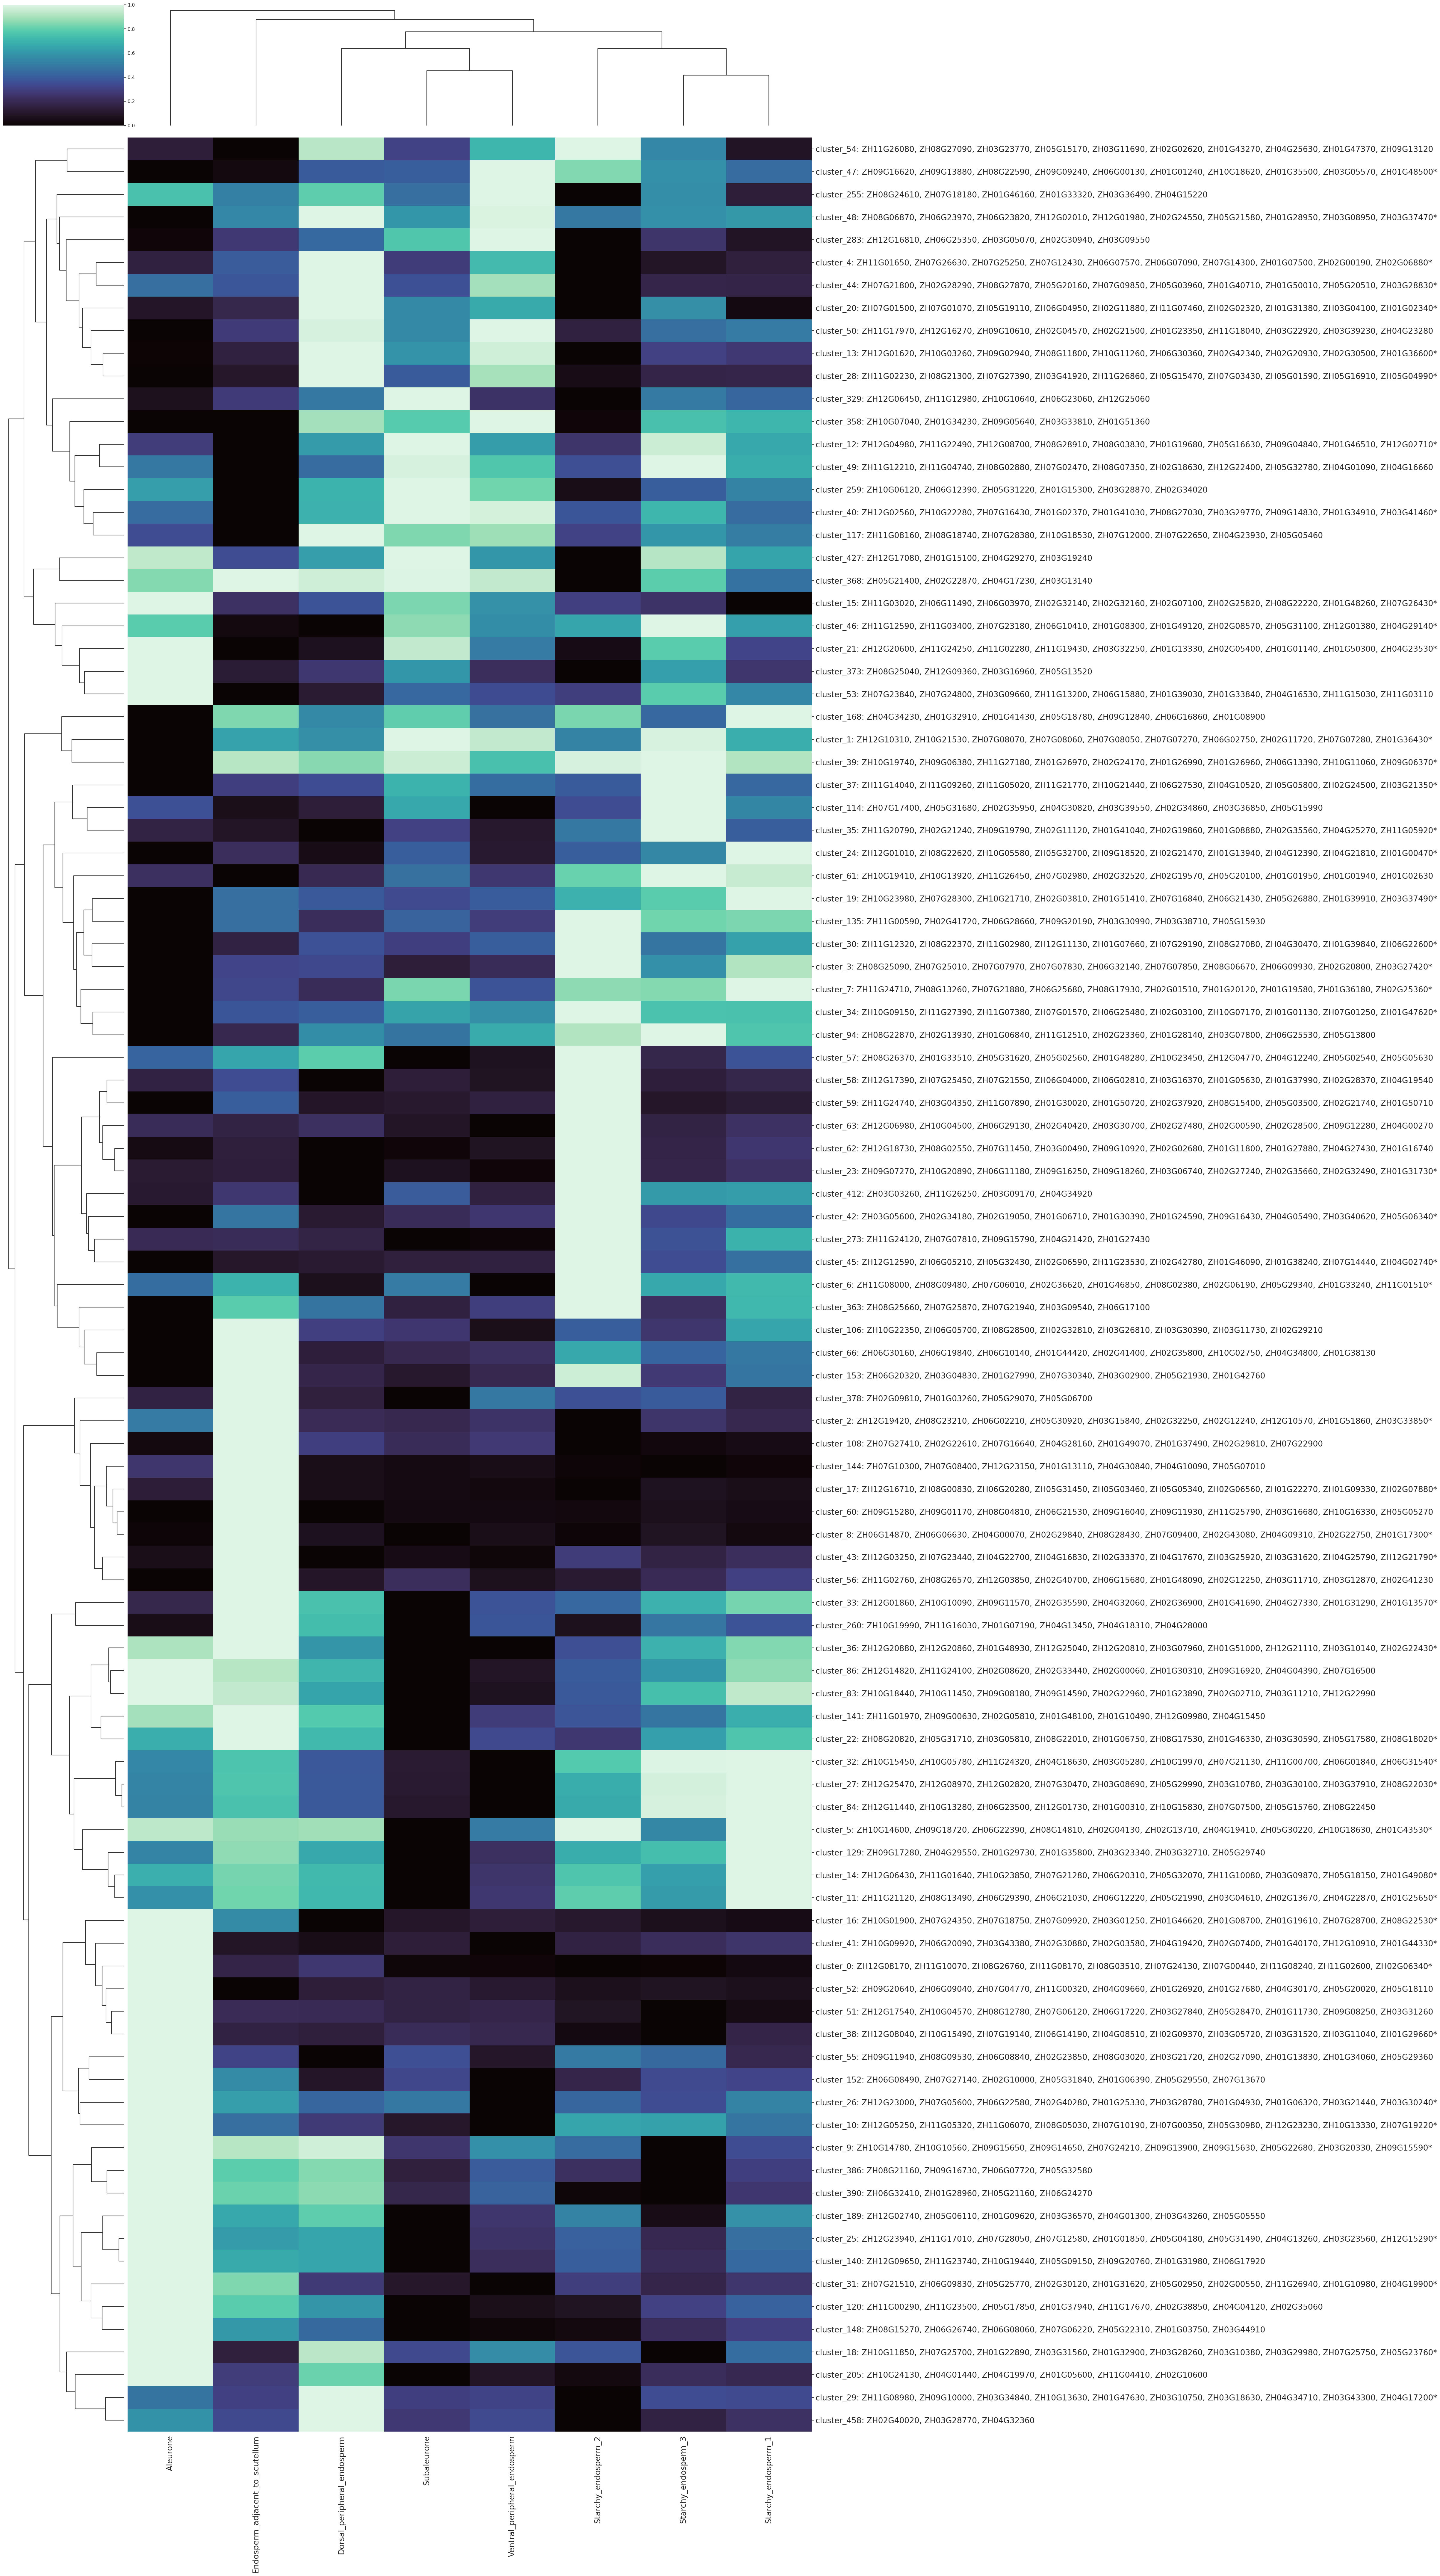

In [34]:
plt.figure(figsize=figsize)
g=sns.clustermap(
    df,
    figsize=figsize,
    # dendrogram_ratio=0.3
    dendrogram_ratio=(0.15, 0.05),  # 行树状图变长，列树状图变短,行树状图位于图像左侧，列树状图位于图像的上方
    # dendrogram_ratio=(0.2, 0.1),
    cmap="mako",
    yticklabels=True,
    standard_scale=0,
    # cbar_pos=(0.05, 0.1, 0.02, 0.4)  # 调整颜色条的宽度，(left, bottom, width, height)
    #树状图线的更粗
    tree_kws={'linewidths': 1.5},  # 增加树状图线条的粗细
)

    # 调整热力图基因标签的字体大小
for label in g.ax_heatmap.get_yticklabels():
    label.set_fontsize(19)  # 设置基因标签字体大小
    # 调整列标签的字体大小
for label in g.ax_heatmap.get_xticklabels():
    label.set_fontsize(19)  # 设置列标签字体大小

#缩小列树状图和热图的间隔
plt.subplots_adjust(left=0.05, right=0.95, bottom=0.05, top=0.95, wspace=0.01, hspace=0.01)
# plt.tight_layout()

# 如果提供了保存路径，保存图像
plt.savefig(plot, bbox_inches='tight')

In [35]:
# CD_genes = mgs['156'] + mgs['14'] + mgs['313']
CD_genes = mgs['25']
df_CD = pd.DataFrame(columns=['Gene', 'Similarity', 'Gene1'])
for i in tqdm.tqdm(CD_genes):
    df = embed.compute_similarities(i, CD_genes)
    df['Gene1'] = i
    df_CD = pd.concat([df_CD, df], ignore_index=True)
df_CD_sub = df_CD[df_CD['Similarity']<0.99].sort_values(by='Gene') # Filter out edges from each gene to itself

100%|██████████| 12/12 [00:00<00:00, 128.94it/s]


In [42]:
df_CD_sub.to_csv("Cluster_Gene_to_Gene_scores.csv")

In [36]:
# Creates a graph from the cosine similarity network
input_node_weights = [(row['Gene'], row['Gene1'], round(row['Similarity'], 2)) for i, row in df_CD_sub.iterrows()]
G = nx.Graph()
G.add_weighted_edges_from(input_node_weights)

In [40]:
# Plot the cosine similarity network; strong edges (> select threshold) are highlighted
thresh = 0.4
plt.figure(figsize=(20, 20))
widths = nx.get_edge_attributes(G, 'weight')

elarge = [(u, v) for (u, v, d) in G.edges(data=True) if d["weight"] > thresh]
esmall = [(u, v) for (u, v, d) in G.edges(data=True) if d["weight"] <= thresh]

pos = nx.spring_layout(G, k=0.4, iterations=15, seed=3)

width_large = {}
width_small = {}
for i, v in enumerate(list(widths.values())):
    if v > thresh:
        width_large[list(widths.keys())[i]] = v*10
    else:
        width_small[list(widths.keys())[i]] = max(v, 0)*10

nx.draw_networkx_edges(G, pos,
                       edgelist = width_small.keys(),
                       width=list(width_small.values()),
                       edge_color='lightblue',
                       alpha=0.8)
nx.draw_networkx_edges(G, pos, 
                       edgelist = width_large.keys(), 
                       width = list(width_large.values()), 
                       alpha = 0.5, 
                       edge_color = "blue", 
                      )
# node labels
nx.draw_networkx_labels(G, pos, font_size=25, font_family="sans-serif")
# edge weight labels
d = nx.get_edge_attributes(G, "weight")
edge_labels = {k: d[k] for k in elarge}
nx.draw_networkx_edge_labels(G, pos, edge_labels, font_size=15)

ax = plt.gca()
ax.margins(0.08)
plt.axis("off")
plt.title("")
plt.savefig("D5-15_celltype_part_hvg3000_Bsample_ckpt_add_szs-df_C25.pdf")
plt.close()

## Step 4: Visualize gene program activation on the Immune Human dataset

In [24]:
# sns.set(font_scale=1)
# embed.score_metagenes(adata, metagenes)
# embed.plot_metagenes_scores(adata, mgs, "celltype")

## Step 5: Visualize network connectivity within desired gene program
We can further visualize the connectivity between genes within any gene program of interest from Step 4. Here is an example of gene program 3 consisting of the CD3 cluster, CD8 cluster and other genes. In the visualization, we see strong connections highlighted in blue (by cosine similarity) between CD3D, E, and G, as well as CD8A and B.

In [15]:
import os

# 给定的字符串列表
clusters = [
    "cluster_25", "cluster_140", "cluster_189", "cluster_29", "cluster_120",
    "cluster_205", "cluster_9", "cluster_386", "cluster_148", "cluster_31",
    "cluster_18", "cluster_458", "cluster_390", "cluster_27", "cluster_36",
    "cluster_86", "cluster_84", "cluster_14", "cluster_33", "cluster_141",
    "cluster_260", "cluster_83", "cluster_32", "cluster_5", "cluster_22",
    "cluster_11", "cluster_129"
]

# 遍历列表，提取数字并创建文件夹
for cluster in clusters:
    # 提取 '_' 后面的数字（如 "cluster_25" → "25"）    
    # 创建文件夹（如果不存在）
    folder_name = "/hy-tmp/lcx/zh11_rice_data/GRN/D5-15/" + cluster
    if not os.path.exists(folder_name):
        os.makedirs(folder_name)
        print(f"文件夹 '{folder_name}' 已创建。")
    else:
        print(f"文件夹 '{folder_name}' 已存在，跳过。")

    number = cluster.split('_')[1]

    CD_genes = mgs[number]

    df_CD = pd.DataFrame(columns=['Gene', 'Similarity', 'Gene1'])
    for i in tqdm.tqdm(CD_genes):
        df = embed.compute_similarities(i, CD_genes)
        df['Gene1'] = i
        df_CD = pd.concat([df_CD, df], ignore_index=True)
    df_CD_sub = df_CD[df_CD['Similarity']<0.99].sort_values(by='Gene')

    input_node_weights = [(row['Gene'], row['Gene1'], round(row['Similarity'], 2)) for i, row in df_CD_sub.iterrows()]
    G = nx.Graph()
    G.add_weighted_edges_from(input_node_weights)

    # Plot the cosine similarity network; strong edges (> select threshold) are highlighted
    thresh_lits = [0.4,0.5,0.6,0.7,0.8,0.9]

    for thresh in thresh_lits: 
        plt.figure(figsize=(20, 20))
        widths = nx.get_edge_attributes(G, 'weight')

        elarge = [(u, v) for (u, v, d) in G.edges(data=True) if d["weight"] > thresh]
        esmall = [(u, v) for (u, v, d) in G.edges(data=True) if d["weight"] <= thresh]

        pos = nx.spring_layout(G, k=0.4, iterations=15, seed=3)

        width_large = {}
        width_small = {}
        for i, v in enumerate(list(widths.values())):
            if v > thresh:
                width_large[list(widths.keys())[i]] = v*10
            else:
                width_small[list(widths.keys())[i]] = max(v, 0)*10

        nx.draw_networkx_edges(G, pos,
                            edgelist = width_small.keys(),
                            width=list(width_small.values()),
                            edge_color='lightblue',
                            alpha=0.8)
        nx.draw_networkx_edges(G, pos, 
                            edgelist = width_large.keys(), 
                            width = list(width_large.values()), 
                            alpha = 0.5, 
                            edge_color = "blue", 
                            )
        # node labels
        nx.draw_networkx_labels(G, pos, font_size=25, font_family="sans-serif")
        # edge weight labels
        d = nx.get_edge_attributes(G, "weight")
        edge_labels = {k: d[k] for k in elarge}
        nx.draw_networkx_edge_labels(G, pos, edge_labels, font_size=15)

        ax = plt.gca()
        ax.margins(0.08)
        plt.axis("off")
        plt.title(cluster+" > "+str(thresh),size=30)
        plt.savefig(folder_name+"/"+cluster+">"+str(thresh)+".png")
        plt.close()

文件夹 '/hy-tmp/lcx/zh11_rice_data/GRN/D5-15/cluster_25' 已存在，跳过。


100%|██████████| 12/12 [00:00<00:00, 140.19it/s]


文件夹 '/hy-tmp/lcx/zh11_rice_data/GRN/D5-15/cluster_140' 已存在，跳过。


100%|██████████| 7/7 [00:00<00:00, 212.53it/s]


文件夹 '/hy-tmp/lcx/zh11_rice_data/GRN/D5-15/cluster_189' 已存在，跳过。


100%|██████████| 7/7 [00:00<00:00, 203.40it/s]


文件夹 '/hy-tmp/lcx/zh11_rice_data/GRN/D5-15/cluster_29' 已存在，跳过。


100%|██████████| 11/11 [00:00<00:00, 153.23it/s]


文件夹 '/hy-tmp/lcx/zh11_rice_data/GRN/D5-15/cluster_120' 已存在，跳过。


100%|██████████| 8/8 [00:00<00:00, 204.71it/s]


文件夹 '/hy-tmp/lcx/zh11_rice_data/GRN/D5-15/cluster_205' 已存在，跳过。


100%|██████████| 6/6 [00:00<00:00, 218.04it/s]


文件夹 '/hy-tmp/lcx/zh11_rice_data/GRN/D5-15/cluster_9' 已存在，跳过。


100%|██████████| 15/15 [00:00<00:00, 115.78it/s]


文件夹 '/hy-tmp/lcx/zh11_rice_data/GRN/D5-15/cluster_386' 已存在，跳过。


100%|██████████| 4/4 [00:00<00:00, 220.32it/s]


文件夹 '/hy-tmp/lcx/zh11_rice_data/GRN/D5-15/cluster_148' 已存在，跳过。


100%|██████████| 7/7 [00:00<00:00, 194.05it/s]


文件夹 '/hy-tmp/lcx/zh11_rice_data/GRN/D5-15/cluster_31' 已存在，跳过。


100%|██████████| 11/11 [00:00<00:00, 159.94it/s]


文件夹 '/hy-tmp/lcx/zh11_rice_data/GRN/D5-15/cluster_18' 已存在，跳过。


100%|██████████| 13/13 [00:00<00:00, 146.98it/s]


文件夹 '/hy-tmp/lcx/zh11_rice_data/GRN/D5-15/cluster_458' 已存在，跳过。


100%|██████████| 3/3 [00:00<00:00, 357.84it/s]


文件夹 '/hy-tmp/lcx/zh11_rice_data/GRN/D5-15/cluster_390' 已存在，跳过。


100%|██████████| 4/4 [00:00<00:00, 299.23it/s]


文件夹 '/hy-tmp/lcx/zh11_rice_data/GRN/D5-15/cluster_27' 已存在，跳过。


100%|██████████| 12/12 [00:00<00:00, 158.12it/s]


文件夹 '/hy-tmp/lcx/zh11_rice_data/GRN/D5-15/cluster_36' 已存在，跳过。


100%|██████████| 11/11 [00:00<00:00, 124.69it/s]


文件夹 '/hy-tmp/lcx/zh11_rice_data/GRN/D5-15/cluster_86' 已存在，跳过。


100%|██████████| 9/9 [00:00<00:00, 171.86it/s]


文件夹 '/hy-tmp/lcx/zh11_rice_data/GRN/D5-15/cluster_84' 已存在，跳过。


100%|██████████| 9/9 [00:00<00:00, 197.49it/s]


文件夹 '/hy-tmp/lcx/zh11_rice_data/GRN/D5-15/cluster_14' 已存在，跳过。


100%|██████████| 13/13 [00:00<00:00, 125.72it/s]


文件夹 '/hy-tmp/lcx/zh11_rice_data/GRN/D5-15/cluster_33' 已存在，跳过。


100%|██████████| 11/11 [00:00<00:00, 154.93it/s]


文件夹 '/hy-tmp/lcx/zh11_rice_data/GRN/D5-15/cluster_141' 已存在，跳过。


100%|██████████| 7/7 [00:00<00:00, 212.80it/s]


文件夹 '/hy-tmp/lcx/zh11_rice_data/GRN/D5-15/cluster_260' 已存在，跳过。


100%|██████████| 6/6 [00:00<00:00, 224.78it/s]


文件夹 '/hy-tmp/lcx/zh11_rice_data/GRN/D5-15/cluster_83' 已存在，跳过。


100%|██████████| 9/9 [00:00<00:00, 159.53it/s]


文件夹 '/hy-tmp/lcx/zh11_rice_data/GRN/D5-15/cluster_32' 已存在，跳过。


100%|██████████| 11/11 [00:00<00:00, 152.46it/s]


文件夹 '/hy-tmp/lcx/zh11_rice_data/GRN/D5-15/cluster_5' 已存在，跳过。


100%|██████████| 16/16 [00:00<00:00, 103.32it/s]


文件夹 '/hy-tmp/lcx/zh11_rice_data/GRN/D5-15/cluster_22' 已存在，跳过。


100%|██████████| 12/12 [00:00<00:00, 135.82it/s]


文件夹 '/hy-tmp/lcx/zh11_rice_data/GRN/D5-15/cluster_11' 已存在，跳过。


100%|██████████| 15/15 [00:00<00:00, 109.74it/s]


文件夹 '/hy-tmp/lcx/zh11_rice_data/GRN/D5-15/cluster_129' 已存在，跳过。


100%|██████████| 7/7 [00:00<00:00, 167.51it/s]


In [ ]:
# Retrieve gene program 3 which contains the CD3 gene set
CD_genes = mgs['25']
# CD_genes = ['ZH07G26810', 'ZH01G40500', 'ZH07G15600', 'ZH01G12300', 'ZH01G11280', 'ZH02G21030', 'ZH05G19000', 'ZH01G32180', 'ZH05G14990', 'ZH05G15700']
# CD_genes = ['ZH08G25610', 'ZH09G06590', 'ZH05G15750', 'ZH02G34250', 'ZH02G14590']
# print(CD_genes)
# Compute cosine similarities among genes in this gene program
df_CD = pd.DataFrame(columns=['Gene', 'Similarity', 'Gene1'])
for i in tqdm.tqdm(CD_genes):
    df = embed.compute_similarities(i, CD_genes)
    df['Gene1'] = i
    df_CD = pd.concat([df_CD, df], ignore_index=True)
df_CD_sub = df_CD[df_CD['Similarity']<0.99].sort_values(by='Gene') # Filter out edges from each gene to itself

In [ ]:
df_CD_sub

In [ ]:
# Creates a graph from the cosine similarity network
input_node_weights = [(row['Gene'], row['Gene1'], round(row['Similarity'], 2)) for i, row in df_CD_sub.iterrows()]
G = nx.Graph()
G.add_weighted_edges_from(input_node_weights)

In [ ]:
# Plot the cosine similarity network; strong edges (> select threshold) are highlighted
thresh = 0.5
plt.figure(figsize=(20, 20))
widths = nx.get_edge_attributes(G, 'weight')

elarge = [(u, v) for (u, v, d) in G.edges(data=True) if d["weight"] > thresh]
esmall = [(u, v) for (u, v, d) in G.edges(data=True) if d["weight"] <= thresh]

pos = nx.spring_layout(G, k=0.4, iterations=15, seed=3)

width_large = {}
width_small = {}
for i, v in enumerate(list(widths.values())):
    if v > thresh:
        width_large[list(widths.keys())[i]] = v*10
    else:
        width_small[list(widths.keys())[i]] = max(v, 0)*10

nx.draw_networkx_edges(G, pos,
                       edgelist = width_small.keys(),
                       width=list(width_small.values()),
                       edge_color='lightblue',
                       alpha=0.8)
nx.draw_networkx_edges(G, pos, 
                       edgelist = width_large.keys(), 
                       width = list(width_large.values()), 
                       alpha = 0.5, 
                       edge_color = "blue", 
                      )
# node labels
nx.draw_networkx_labels(G, pos, font_size=25, font_family="sans-serif")
# edge weight labels
d = nx.get_edge_attributes(G, "weight")
edge_labels = {k: d[k] for k in elarge}
nx.draw_networkx_edge_labels(G, pos, edge_labels, font_size=15)

ax = plt.gca()
ax.margins(0.08)
plt.axis("off")
plt.title("Cluster2 > "+str(thresh),size=30)
plt.show(False)